In [1]:
%pip install -q pandas scikit-learn matplotlib

import sys, pandas as pd, sklearn, matplotlib
print("Python:", sys.version.split()[0])
print("pandas:", pd.__version__)
print("scikit-learn:", sklearn.__version__)
print("matplotlib:", matplotlib.__version__)

Note: you may need to restart the kernel to use updated packages.
Python: 3.13.5
pandas: 2.2.3
scikit-learn: 1.6.1
matplotlib: 3.10.0


In [2]:
import pandas as pd

df = pd.read_csv("dataset.txt", sep=",", header=None, names=["x", "y", "dbh"])

Shape: (960, 3)
   x  y   dbh
0  0  0  1.05
1  0  1  1.43
2  0  2  1.19
3  0  3  1.03
4  0  4  1.36


In [3]:
print("Columns:", df.columns.tolist())
print("\nInfo:")
display(df.info())
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nBasic stats:")
display(df.describe())

Columns: ['x', 'y', 'dbh']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       960 non-null    int64  
 1   y       960 non-null    int64  
 2   dbh     960 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 22.6 KB


None


Missing values per column:
x      0
y      0
dbh    0
dtype: int64

Basic stats:


,x,y,dbh
count,960.000000,960.000000,960.000000
mean,11.500000,19.500000,2.215781
std,6.925795,11.549413,0.871604
min,0.000000,0.000000,0.380000
25%,5.750000,9.750000,1.600000
50%,11.500000,19.500000,2.090000
75%,17.250000,29.250000,2.752500
max,23.000000,39.000000,6.660000


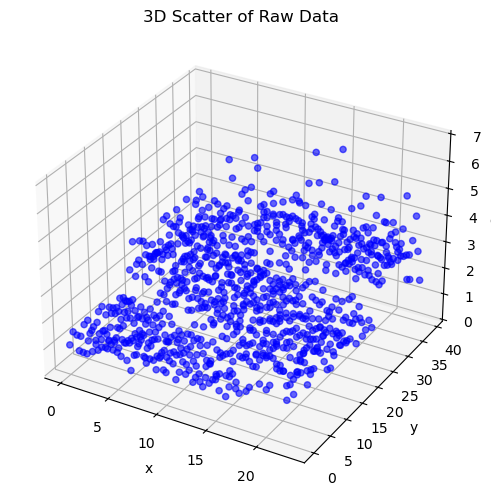

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(df["x"], df["y"], df["dbh"], c="blue", marker="o", alpha=0.6)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("dbh")
plt.title("3D Scatter of Raw Data")
plt.show()

In [5]:
from sklearn.preprocessing import StandardScaler

features = ["x", "y", "dbh"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

import numpy as np
print("Means (should be ~0):", np.mean(X_scaled, axis=0))
print("Standard deviations (should be 1):", np.std(X_scaled, axis=0))

Means (should be ~0): [ 1.18423789e-16  0.00000000e+00 -5.92118946e-17]
Standard deviations (should be 1): [1. 1. 1.]


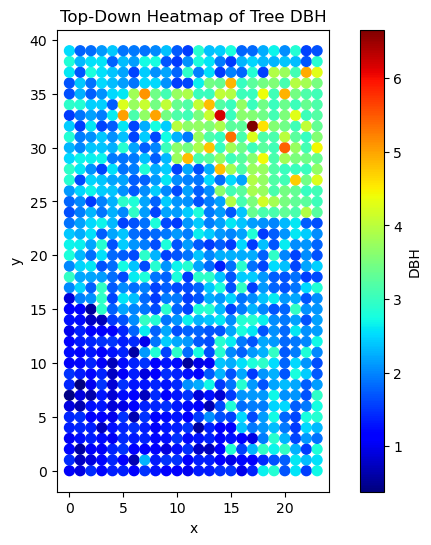

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

plt.scatter(df["x"], df["y"], c=df["dbh"], cmap="jet", s=50)
plt.colorbar(label="DBH")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Top-Down Heatmap of Tree DBH")
plt.gca().set_aspect('equal') 
plt.show()

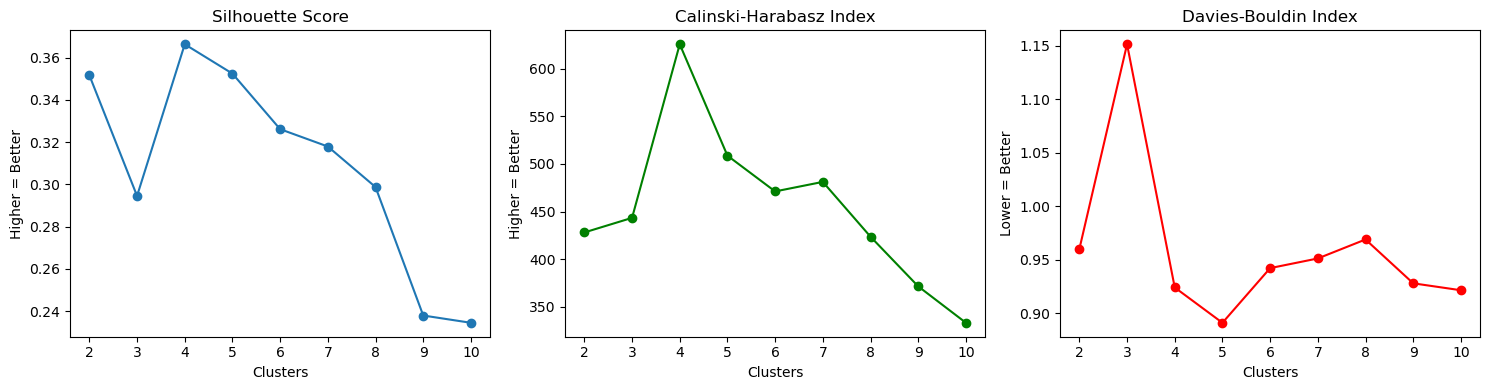

Chosen number of clusters (median): 4
Final cluster counts: {np.int64(0): np.int64(180), np.int64(1): np.int64(385), np.int64(2): np.int64(206), np.int64(3): np.int64(189)}


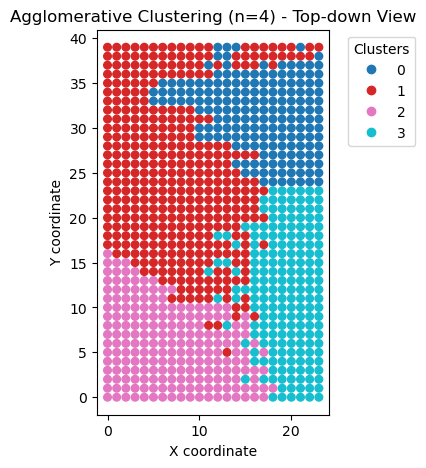

Cluster 0: Best factor = 0.200
Cluster 1: Best factor = 0.200
Cluster 2: Best factor = 0.200
Cluster 3: Best factor = 0.050


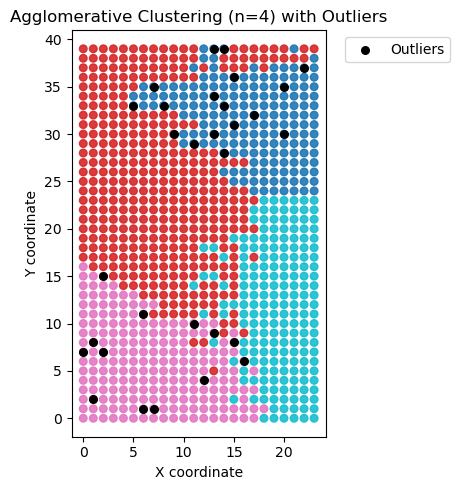

In [21]:
BANDWIDTH = 0.56

FACTOR_MIN = 0.05           
FACTOR_MAX = 0.2            
FACTOR_STEPS = 20           

ATOL = 1e-3                

KDE_GRID_POINTS = 2000      

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# Step 1: Evaluate clustering for n = 2..10
cluster_range = range(2, 11)

silhouette_scores = []
calinski_scores = []
davies_scores = []

for n in cluster_range:
    model = AgglomerativeClustering(
        n_clusters=n, 
        linkage="average", 
        metric="manhattan"
    )
    labels = model.fit_predict(X_scaled)

    silhouette_scores.append(silhouette_score(X_scaled, labels, metric="manhattan"))
    calinski_scores.append(calinski_harabasz_score(X_scaled, labels))
    davies_scores.append(davies_bouldin_score(X_scaled, labels))

# Step 2: Plot evaluation metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(cluster_range, silhouette_scores, marker="o")
axes[0].set_title("Silhouette Score")
axes[0].set_xlabel("Clusters")
axes[0].set_ylabel("Higher = Better")

axes[1].plot(cluster_range, calinski_scores, marker="o", color="green")
axes[1].set_title("Calinski-Harabasz Index")
axes[1].set_xlabel("Clusters")
axes[1].set_ylabel("Higher = Better")

axes[2].plot(cluster_range, davies_scores, marker="o", color="red")
axes[2].set_title("Davies-Bouldin Index")
axes[2].set_xlabel("Clusters")
axes[2].set_ylabel("Lower = Better")

plt.tight_layout()
plt.show()

# Step 3: Pick best n (median of metrics)
best_silhouette_n = cluster_range[np.argmax(silhouette_scores)]
best_calinski_n = cluster_range[np.argmax(calinski_scores)]
best_davies_n = cluster_range[np.argmin(davies_scores)]

chosen_n = int(np.median([best_silhouette_n, best_calinski_n, best_davies_n]))
print(f"Chosen number of clusters (median): {chosen_n}")

# Step 4: Final clustering
final_model = AgglomerativeClustering(
    n_clusters=chosen_n, 
    linkage="average", 
    metric="manhattan"
)
final_labels = final_model.fit_predict(X_scaled)

(unique, counts) = np.unique(final_labels, return_counts=True)
print("Final cluster counts:", dict(zip(unique, counts)))

# Step 5: Top-down cluster plot using original coordinates
plt.figure(figsize=(3, 5))
scatter = plt.scatter(
    df["x"], df["y"], 
    c=final_labels, cmap="tab10", s=30, alpha=1
)
plt.title(f"Agglomerative Clustering (n={chosen_n}) - Top-down View")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.legend(*scatter.legend_elements(), title="Clusters", loc="upper left", bbox_to_anchor=(1.05, 1))
plt.show()

# Step 6: KDE-based outlier detection with factor search
cluster_outliers = {}

for c in np.unique(final_labels):
    values = df.loc[final_labels == c, "dbh"].values
    cluster_indices = np.where(final_labels == c)[0]

    if len(values) < 2:
        cluster_outliers[c] = []
        continue

    kde = gaussian_kde(values, bw_method=BANDWIDTH)
    x_grid = np.linspace(values.min(), values.max(), KDE_GRID_POINTS)
    density = kde(x_grid)

    best_factor = FACTOR_MIN
    best_score = -np.inf

    for factor in np.linspace(FACTOR_MIN, FACTOR_MAX, FACTOR_STEPS):
        cutoff = factor * max(density)
        valley_mask = density < cutoff
        score = np.sum(valley_mask) / len(valley_mask)  # More valleys = higher score
        if score > best_score:
            best_score = score
            best_factor = factor

    cutoff = best_factor * max(density)
    outlier_mask_grid = density < cutoff
    outlier_values = x_grid[outlier_mask_grid]

    outliers = []
    for idx, val in zip(cluster_indices, values):
        if np.any(np.isclose(val, outlier_values, atol=ATOL)):
            outliers.append(idx)

    cluster_outliers[c] = outliers
    print(f"Cluster {c}: Best factor = {best_factor:.3f}")

plt.figure(figsize=(4.6, 5))
plt.scatter(df["x"], df["y"], c=final_labels, cmap="tab10", s=30, alpha=0.9)

all_outlier_indices = [idx for outliers in cluster_outliers.values() for idx in outliers]
plt.scatter(df.loc[all_outlier_indices, "x"], df.loc[all_outlier_indices, "y"], c="black", s=30, label="Outliers")

plt.title(f"Agglomerative Clustering (n={chosen_n}) with Outliers")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()
